### Pair Programming Decision Tree

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Decision Tree en este tipo de problemas. Los objetivos de este pair programming :

1. Ajustad un modelo de Decision Tree a nuestros datos.

2. Calculad las métricas a nuestro nuevo modelo.

3. Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [25]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

### 1. Ajustad un modelo de Decision Tree a nuestros datos.

In [26]:
#Abrimos df estandarizado
df=pd.read_csv('datos/diamonds_def.csv', index_col=0)
df.head(3)

,est_carat,est_depth,est_table,est_price,est_lenght_mm,est_width_mm,est_depth_mm,cut_encoded,clarity_encoded,color_encoded
1,-1.268160,-1.597233,1.661056,-0.986397,-1.646799,-1.705394,-1.780396,5,3,2
2,-1.224362,0.042616,3.519383,-0.986075,-1.503737,-1.498268,-1.780396,4,1,2
3,-1.092965,0.534571,0.267310,-0.983820,-1.369617,-1.354180,-1.316852,2,4,2


In [27]:
#Separamos el df de la VR.
x = df.drop("est_carat", axis = 1) #Este es el df sin la VR.
y = df["est_carat"] #VR.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [29]:
# creamos modelo Ramdom Forest 
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [30]:
#llamamos al max features y hacemos la raíz cuadrada:
max_features = np.sqrt(len(x_train.columns))
print(f'La raíz cuadrada de las columnas del df de entrenamiento es de {max_features}.')

#exploramos la profundidad de nuestro modelo:
print(f'La profundidad de nuestro arbol es de {arbol.tree_.max_depth}.')


La raíz cuadrada de las columnas del df de entrenamiento es de 3.0.
La profundidad de nuestro arbol es de 35.


In [31]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [32]:
#invocamos la función para extraer las métricas del test y del train:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [33]:
# Aplicamos la función para ver si hay overfitting o unerfitting y
# modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,2.434035e-02,1.702532e-02,1.304811e-01,0.982897,test,Decision Tree I
1,2.685032e-17,8.413105e-33,9.172298e-17,1.000000,train,Decision Tree I


#### INTERPRETACION

Observamos un dato que nos llama la atencion, el resultado del R2 (1), dado que es una probabilidad bastante improbable que suceda.

In [34]:
# creamos diccionario donde establecer los parámetros para nuestro modelo

param = {"max_depth": [3,7,17], #La pofundidad del arbol es de 35. Facilitamos parámetros que nos permitan dividir por la mitad para ajustar lo máximo posible.
        "max_features": [1,2,3],#El rdo. de la raiz cuadrada es de 3 por lo que pasamos parametros inferiores para volver a ajustar correctamente.
        "min_samples_split": [500, 1000, 1500], #Asociamos estos 3 parametros al nodo madre para reducir el overfitting. 
        "min_samples_leaf": [300,800,1300]} #Asociamos estos 3 parametros al nodo hijo para reducir el overfitting.

In [35]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [36]:
#ajustamos en el modelo los datos de entrenamiento
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 7, 17], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [300, 800, 1300],
                         'min_samples_split': [500, 1000, 1500]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [37]:
#extraemos el mejor modelo:
best_model = gs.best_estimator_
best_model

DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=300,
                      min_samples_split=500)

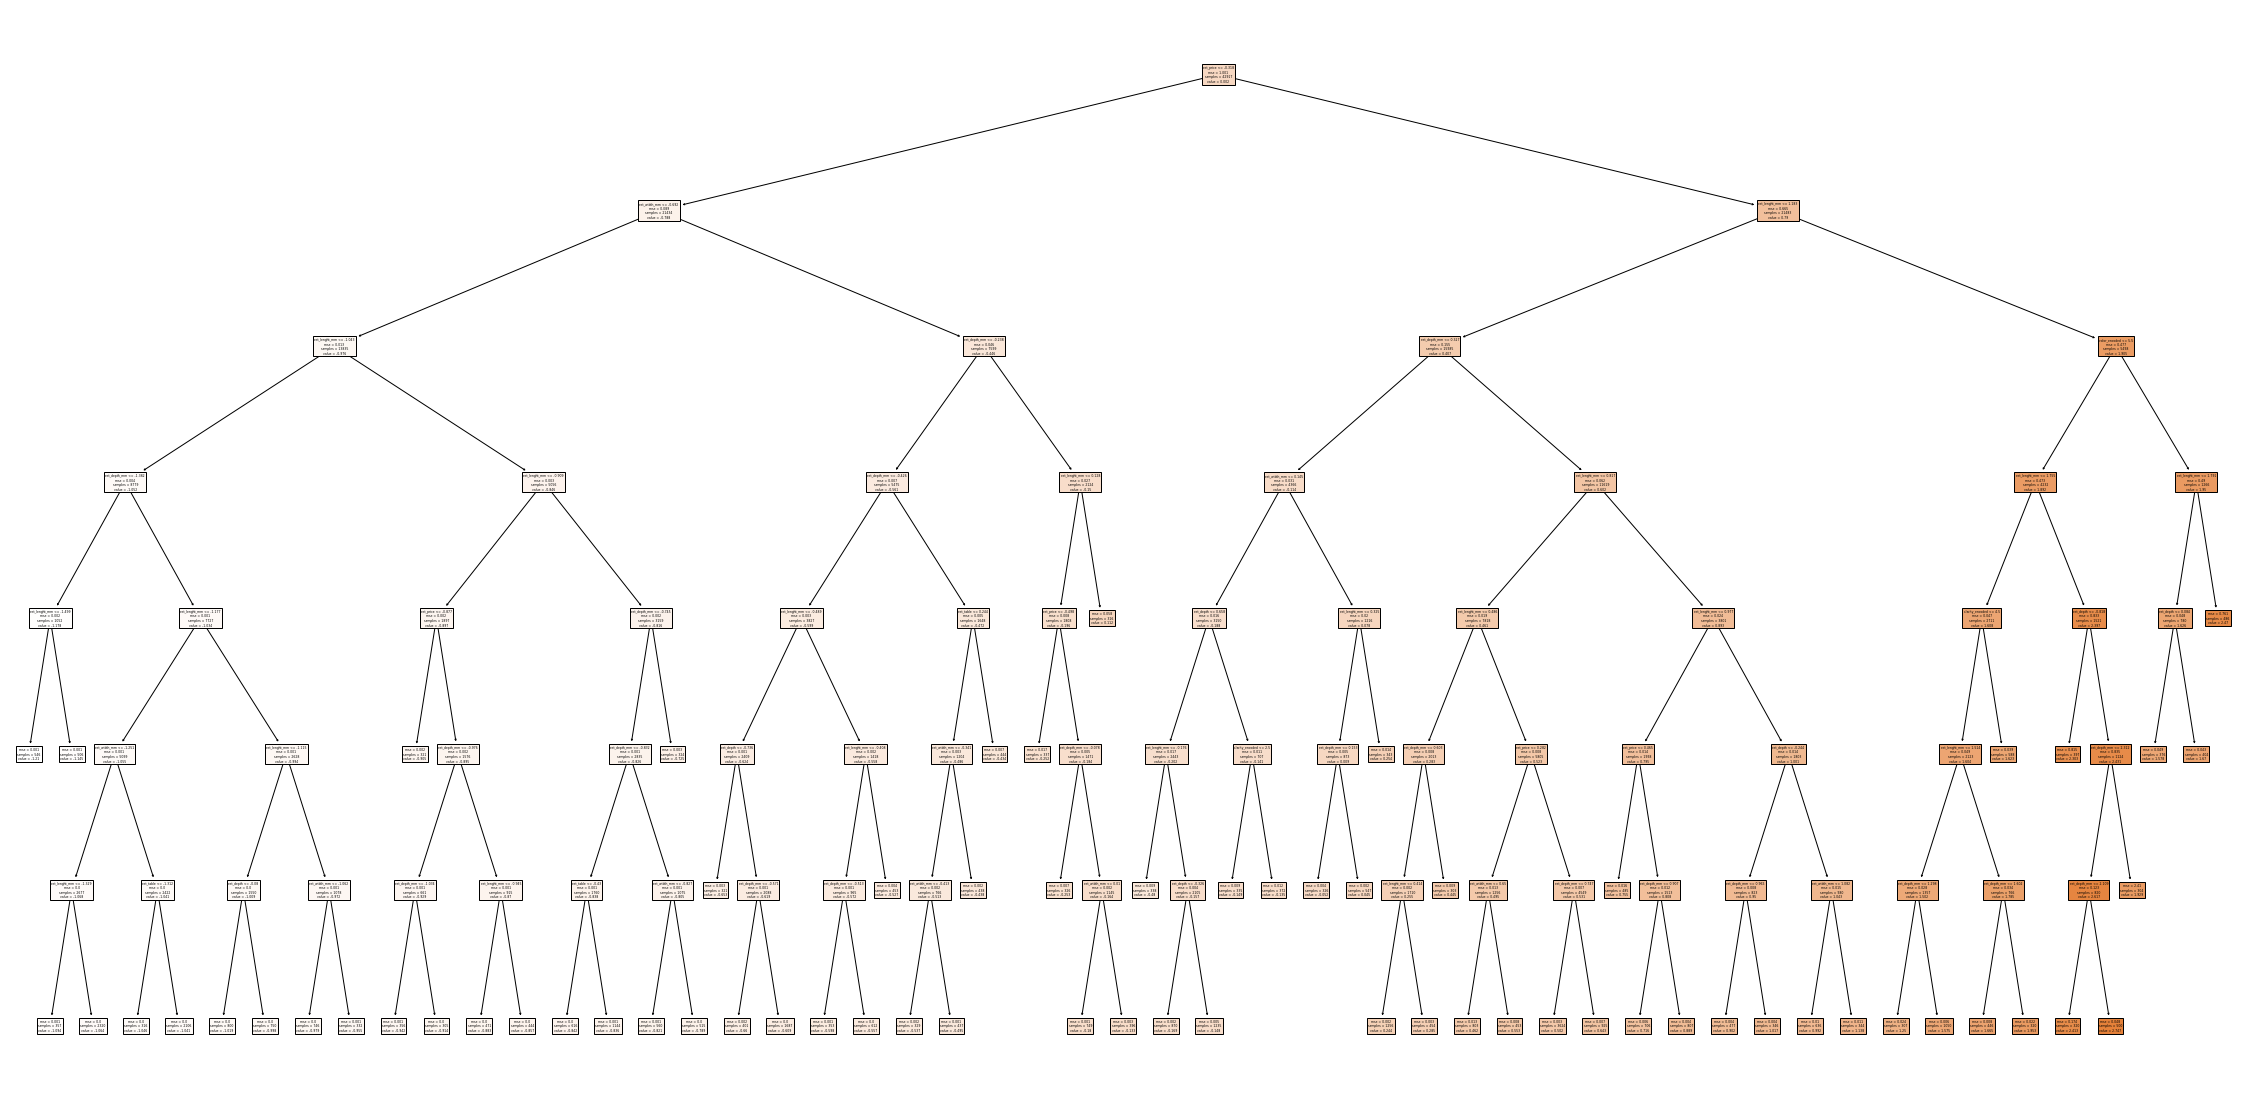

In [49]:
# vamos a representar nuestro árbol gráficamente:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(best_model, feature_names=x_train.columns, filled=True);

In [38]:
# predecimos el valor de la VR según el mejor modelo:
y_pred_test_dt2 = best_model.predict(x_test)
y_pred_train_dt2 = best_model.predict(x_train)

In [39]:
dt_results_BM = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results_BM

,MAE,MSE,RMSE,R2,set,modelo
0,0.064456,0.041587,0.203930,0.958224,test,Decision tree II
1,0.064136,0.040166,0.200416,0.959865,train,Decision tree II


In [40]:
# Unimos los df de los resultados de los modelos para poder compararlos mejor
df_decision_results = pd.concat([dt_results1, dt_results_BM], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,2.434035e-02,1.702532e-02,1.304811e-01,0.982897,test,Decision Tree I
1,2.685032e-17,8.413105e-33,9.172298e-17,1.000000,train,Decision Tree I
0,6.445637e-02,4.158741e-02,2.039299e-01,0.958224,test,Decision tree II
1,6.413595e-02,4.016642e-02,2.004156e-01,0.959865,train,Decision tree II


In [44]:
#abrimos un csv con los resultados de las métricas de modelos anteriores de RL:
df_resultados_metricas = pd.read_csv("datos/diamonds_rdos_metricas.csv", index_col=0)
df_resultados_metricas.head(2)

,MAE,MSE,RMSE,R2,set,modelo
0,0.151985,0.074438,0.272832,0.925224,test,Linear Regresion
1,0.149743,0.071913,0.268167,0.928142,train,LinearRegression


In [45]:
# Unimos los df de los resultados de los modelos para poder comparar 
# todos los resultados obtenidos
df_metricas_RL_DT = pd.concat([df_decision_results, df_resultados_metricas ], axis = 0)
df_metricas_RL_DT.head(6)

,MAE,MSE,RMSE,R2,set,modelo
0,2.434035e-02,1.702532e-02,1.304811e-01,0.982897,test,Decision Tree I
1,2.685032e-17,8.413105e-33,9.172298e-17,1.000000,train,Decision Tree I
0,6.445637e-02,4.158741e-02,2.039299e-01,0.958224,test,Decision tree II
1,6.413595e-02,4.016642e-02,2.004156e-01,0.959865,train,Decision tree II
0,1.519848e-01,7.443756e-02,2.728325e-01,0.925224,test,Linear Regresion
1,1.497432e-01,7.191349e-02,2.681669e-01,0.928142,train,LinearRegression


> Vemos que el modelo que mejor se ajusta es el obtenido en el segundo arbol de Decision Tree II, donde apreciamos que en el entrenamiento predice de manera que se aproxima a una relacion casi perfecta (R2=0.95), y en el resto de las métricas, no observamos que exista un overfitting. Siendo este modelo el que tiene un mejor ajuste que el resto de modelos.